In [1]:
# Not needed.  Code is embedded in stress modules.
# Adds lag and exponent columns to hist_all.csv and CCARscen_all.csv tables.
# 20170410: expanded to handle CCAR sUE adjustments through 2017
# 20180314: expanded to handle CCAR sUE adjustments through 2018
# creates UE_adj.csv file for sUE calcs
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
## new file for econ variables only:  add lags, exponents, then save for future use.
cc = pd.read_csv("CCARscen_all.csv")  ## CCAR scenarios for all years
hs = pd.read_csv("hist_all.csv")  ## history of all macroeconomic variables

cc['Date'] = pd.to_datetime(cc['Date'])
hs['Date'] = pd.to_datetime(hs['Date'])

In [3]:
## history vars: 4q lags & 4q differences for UE, HPI, CRE (also, try 6q & 8q lags for UE only)
hs['UE_4'] = hs['UE'].shift(4)  ## add 4q lag version of UE
hs['HPI_4'] = hs['HPI'].shift(4)
hs['CRE_4'] = hs['CRE'].shift(4)

## history vars: squared terms for UE and UE_4:
hs['UE2'] = hs['UE'] * hs['UE']
hs['UE_42'] = hs['UE_4'] * hs['UE_4']

hsx = hs.copy()
hsx[hsx['Date']>'2001-01-01'].tail()

Date  rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  ...    \
163 2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2  ...     
164 2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5  ...     
165 2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3  ...     
166 2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3  ...     
167 2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4  ...     

     Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2  UE_42  
163    3.5  23277.0  184.0  269.0  22.5   5.0  175.0  254.0  22.09  25.00  
164    3.8  24508.0  187.0  262.0  13.1   4.9  177.0  245.0  22.09  24.01  
165    4.0  25125.0  190.0  272.0  16.0   4.9  179.0  248.0  18.49  24.01  
166    4.3  26149.0  193.0  275.0  16.0   4.9  182.0  266.0  18.49  24.01  
167    4.3  27673.0  194.0  279.0  13.1   4.7  184.0  269.0  16.81  22.09  

[5 rows x 22 columns]

In [4]:
hsx.to_csv("hist_lagexp.csv")
hsy = hsx[hsx['Date']>'2001-01-01'].copy()
hsy.set_index('Date',drop=True,inplace=True)
hsy.tail()

rGDPg  nGDPg  rDIg  nDIg   UE  CPI  T3m  T5y  T10y  BBB  ...    \
Date                                                                 ...     
2016-12-31    1.8    3.8  -1.8   0.1  4.7  3.0  0.4  1.7   2.2  4.1  ...     
2017-03-31    1.2    3.3   2.9   5.2  4.7  3.1  0.6  2.0   2.5  4.2  ...     
2017-06-30    3.1    4.1   2.7   3.0  4.3 -0.3  0.9  1.8   2.3  4.0  ...     
2017-09-30    3.2    5.3   0.5   2.1  4.3  2.0  1.0  1.8   2.3  3.9  ...     
2017-12-31    2.7    5.0   1.9   5.6  4.1  3.7  1.2  2.1   2.4  4.0  ...     

            Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4    UE2  \
Date                                                                        
2016-12-31    3.5  23277.0  184.0  269.0  22.5   5.0  175.0  254.0  22.09   
2017-03-31    3.8  24508.0  187.0  262.0  13.1   4.9  177.0  245.0  22.09   
2017-06-30    4.0  25125.0  190.0  272.0  16.0   4.9  179.0  248.0  18.49   
2017-09-30    4.3  26149.0  193.0  275.0  16.0   4.9  182.0  266.0  18.49   
2017-12-31    4.3  27673.0  194.0  279.0  13.1   4.7  184.0  269.0  16.81   

            UE_42  
Date               
2016-12-31  25.00  
2017-03-31  24.01  
2017-06-30  24.01  
2017-09-30  24.01  
2017-12-31  22.09  

[5 rows x 21 columns]

In [5]:
hsy.columns

Index([u'rGDPg', u'nGDPg', u'rDIg', u'nDIg', u'UE', u'CPI', u'T3m', u'T5y',
       u'T10y', u'BBB', u'Mort', u'Prime', u'DJ', u'HPI', u'CRE', u'VIX',
       u'UE_4', u'HPI_4', u'CRE_4', u'UE2', u'UE_42'],
      dtype='object')

In [6]:
ccy = cc.copy()
ccy['UE_4'] = ccy.groupby(['CCAR','Scen'])[['UE']].shift(4)
ccy['HPI_4'] = ccy.groupby(['CCAR','Scen'])[['HPI']].shift(4)
ccy['CRE_4'] = ccy.groupby(['CCAR','Scen'])[['CRE']].shift(4)
#test.columns = ['UE_4','HPI_4','CRE_4']
ccy.tail(26)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE  CPI  T3m  ...    \
251  2018  Adv 2018-03-31   -1.3    1.2   2.4   4.2   4.5  1.7  0.6  ...     
252  2018  Adv 2018-06-30   -3.5   -1.4  -1.2   0.2   5.3  1.3  0.1  ...     
253  2018  Adv 2018-09-30   -2.4   -0.4  -1.8  -0.2   5.8  1.6  0.1  ...     
254  2018  Adv 2018-12-31   -1.3    0.6  -1.1   0.6   6.3  1.7  0.1  ...     
255  2018  Adv 2019-03-31   -0.7    1.3  -0.3   1.5   6.6  1.8  0.1  ...     
256  2018  Adv 2019-06-30    0.4    2.3  -0.1   1.6   6.9  1.9  0.1  ...     
257  2018  Adv 2019-09-30    1.0    2.9   0.5   2.2   7.0  1.9  0.1  ...     
258  2018  Adv 2019-12-31    2.5    4.3   1.0   2.9   7.0  2.1  0.1  ...     
259  2018  Adv 2020-03-31    2.8    4.5   2.3   4.2   6.9  2.1  0.1  ...     
260  2018  Adv 2020-06-30    3.0    4.7   2.4   4.2   6.8  2.0  0.1  ...     
261  2018  Adv 2020-09-30    3.2    4.8   2.6   4.4   6.6  2.0  0.1  ...     
262  2018  Adv 2020-12-31    3.3    4.9   2.8   4.5   6.5  2.0  0.1  ...     
263  2018  Adv 2021-03-31    3.3    4.8   2.9   4.6   6.3  1.9  0.1  ...     
264  2018  Sev 2018-03-31   -4.7   -2.3   1.4   3.0   5.0  1.4  0.1  ...     
265  2018  Sev 2018-06-30   -8.9   -7.1  -4.2  -3.1   6.5  0.9  0.1  ...     
266  2018  Sev 2018-09-30   -6.8   -5.1  -5.1  -3.8   7.6  1.2  0.1  ...     
267  2018  Sev 2018-12-31   -4.7   -3.0  -3.9  -2.5   8.5  1.3  0.1  ...     
268  2018  Sev 2019-03-31   -3.6   -1.8  -2.9  -1.5   9.3  1.5  0.1  ...     
269  2018  Sev 2019-06-30   -1.3    0.3  -2.4  -1.0   9.7  1.5  0.1  ...     
270  2018  Sev 2019-09-30   -0.2    1.4  -1.4  -0.1  10.0  1.5  0.1  ...     
271  2018  Sev 2019-12-31    2.8    4.3  -0.1   1.5   9.9  1.8  0.1  ...     
272  2018  Sev 2020-03-31    3.5    4.8   1.9   3.4   9.7  1.8  0.1  ...     
273  2018  Sev 2020-06-30    4.0    5.2   2.3   3.7   9.5  1.7  0.1  ...     
274  2018  Sev 2020-09-30    4.2    5.3   2.7   4.1   9.2  1.6  0.1  ...     
275  2018  Sev 2020-12-31    4.5    5.5   3.1   4.3   8.9  1.6  0.1  ...     
276  2018  Sev 2021-03-31    4.5    5.4   3.3   4.5   8.6  1.5  0.1  ...     

     BBB  Mort  Prime       DJ    HPI    CRE   VIX  UE_4  HPI_4  CRE_4  
251  3.8   3.2    3.8  24589.0  191.0  272.0  28.0   NaN    NaN    NaN  
252  4.2   3.4    3.3  22884.0  185.0  262.0  33.1   NaN    NaN    NaN  
253  4.4   3.6    3.3  21104.0  180.0  254.0  33.7   NaN    NaN    NaN  
254  4.6   3.7    3.3  20858.0  177.0  247.0  32.8   NaN    NaN    NaN  
255  4.8   3.9    3.2  19718.0  174.0  242.0  31.7   4.5  191.0  272.0  
256  4.8   3.9    3.2  19998.0  172.0  239.0  28.8   5.3  185.0  262.0  
257  4.7   3.9    3.2  20580.0  171.0  237.0  25.7   5.8  180.0  254.0  
258  4.6   3.9    3.2  21350.0  171.0  237.0  23.1   6.3  177.0  247.0  
259  4.6   4.0    3.2  22145.0  171.0  237.0  21.3   6.6  174.0  242.0  
260  4.4   4.0    3.2  23213.0  172.0  238.0  20.1   6.9  172.0  239.0  
261  4.3   4.0    3.2  24259.0  172.0  239.0  19.3   7.0  171.0  237.0  
262  4.2   3.9    3.2  25405.0  173.0  240.0  18.7   7.0  171.0  237.0  
263  4.0   3.9    3.2  26625.0  174.0  242.0  18.3   6.9  171.0  237.0  
264  7.1   5.3    3.3  13466.0  186.0  262.0  50.7   NaN    NaN    NaN  
265  7.7   5.7    3.3  11631.0  171.0  234.0  62.4   NaN    NaN    NaN  
266  7.9   5.8    3.3  10575.0  159.0  212.0  59.5   NaN    NaN    NaN  
267  8.0   5.9    3.3  10306.0  151.0  195.0  52.8   NaN    NaN    NaN  
268  8.1   6.0    3.2   9689.0  143.0  181.0  47.4   5.0  186.0  262.0  
269  7.9   6.0    3.2  10100.0  139.0  173.0  37.9   6.5  171.0  234.0  
270  7.5   5.8    3.2  10949.0  136.0  167.0  29.7   7.6  159.0  212.0  
271  7.1   5.7    3.2  12031.0  136.0  167.0  23.5   8.5  151.0  195.0  
272  6.7   5.5    3.2  13234.0  136.0  167.0  19.8   9.3  143.0  181.0  
273  6.3   5.3    3.2  14713.0  137.0  170.0  17.5   9.7  139.0  173.0  
274  5.9   5.1    3.2  16323.0  139.0  172.0  16.0  10.0  136.0  167.0  
275  5.5   4.9    3.2  18143.0  141.0  176.0  15.0   9.9  136.0  167.0  


In [7]:
for i in np.arange(len(ccy)):
  if np.isnan(ccy.iloc[i]['UE_4']):
    yr = ccy.iloc[i]['Date'].year - 1
    mn = ccy.iloc[i]['Date'].month
    dy = ccy.iloc[i]['Date'].day
    dd = str(datetime(yr,mn,dy))[0:7]
    xu = hsy[dd]['UE'].values
    ccy.loc[i,'UE_4'] = xu
    xh = hsy[dd]['HPI'].values
    ccy.loc[i,'HPI_4'] = xh
    xc = hsy[dd]['CRE'].values
    ccy.loc[i,'CRE_4'] = xc

ccy.head(8)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE   CPI  T3m   ...    \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.00  2.60  0.0   ...     
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.10  1.90  0.1   ...     
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.10  2.00  0.1   ...     
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.00  1.90  0.1   ...     
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.90  2.20  0.1   ...     
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.90  2.10  0.1   ...     
6  2012  Bas 2013-03-31   2.69   4.80  2.77  4.80  8.69  2.11  0.1   ...     
7  2012  Bas 2013-06-30   2.81   5.09  2.89  5.09  8.48  2.27  0.1   ...     

    BBB  Mort  Prime        DJ     HPI     CRE    VIX  UE_4   HPI_4   CRE_4  
0  4.90  4.20    NaN  11677.00  132.00  177.00  48.00   9.5  135.00  165.00  
1  4.52  4.21    NaN  11936.09  137.21  172.17  35.97   9.5  134.00  167.00  
2  4.55  4.17    NaN  12090.22  137.55  173.29  35.08   9.0  133.00  172.00  
3  4.59  4.15    NaN  12242.03  137.89  175.43  31.83   9.1  132.00  173.00  
4  4.74  4.19    NaN  12401.69  138.24  177.65  31.35   9.0  132.00  177.00  
5  4.89  4.24    NaN  12562.14  138.58  178.87  29.59   9.1  137.21  172.17  
6  5.15  4.34    NaN  12725.49  138.93  182.28  28.43   9.1  137.55  173.29  
7  5.32  4.41    NaN  12899.23  139.28  185.64  30.74   9.0  137.89  175.43  

[8 rows x 22 columns]

In [8]:
ccy['UE2'] = ccy['UE'] * ccy['UE']
ccy['UE_42'] = ccy['UE_4'] * ccy['UE_4']
ccy.to_csv('CCARscen_lagexp.csv')
ccy.head(8)

CCAR Scen       Date  rGDPg  nGDPg  rDIg  nDIg    UE   CPI  T3m  ...    \
0  2012  Bas 2011-09-30   0.80   3.30  2.10  4.30  9.00  2.60  0.0  ...     
1  2012  Bas 2011-12-31   2.33   5.22 -0.48  2.01  9.10  1.90  0.1  ...     
2  2012  Bas 2012-03-31   1.92   4.76  1.62  3.50  9.10  2.00  0.1  ...     
3  2012  Bas 2012-06-30   2.22   4.60  2.09  3.88  9.00  1.90  0.1  ...     
4  2012  Bas 2012-09-30   2.43   4.82  1.99  4.09  8.90  2.20  0.1  ...     
5  2012  Bas 2012-12-31   2.63   4.77  2.39  4.40  8.90  2.10  0.1  ...     
6  2012  Bas 2013-03-31   2.69   4.80  2.77  4.80  8.69  2.11  0.1  ...     
7  2012  Bas 2013-06-30   2.81   5.09  2.89  5.09  8.48  2.27  0.1  ...     

   Prime        DJ     HPI     CRE    VIX  UE_4   HPI_4   CRE_4      UE2  \
0    NaN  11677.00  132.00  177.00  48.00   9.5  135.00  165.00  81.0000   
1    NaN  11936.09  137.21  172.17  35.97   9.5  134.00  167.00  82.8100   
2    NaN  12090.22  137.55  173.29  35.08   9.0  133.00  172.00  82.8100   
3    NaN  12242.03  137.89  175.43  31.83   9.1  132.00  173.00  81.0000   
4    NaN  12401.69  138.24  177.65  31.35   9.0  132.00  177.00  79.2100   
5    NaN  12562.14  138.58  178.87  29.59   9.1  137.21  172.17  79.2100   
6    NaN  12725.49  138.93  182.28  28.43   9.1  137.55  173.29  75.5161   
7    NaN  12899.23  139.28  185.64  30.74   9.0  137.89  175.43  71.9104   

   UE_42  
0  90.25  
1  90.25  
2  81.00  
3  82.81  
4  81.00  
5  82.81  
6  82.81  
7  81.00  

[8 rows x 24 columns]

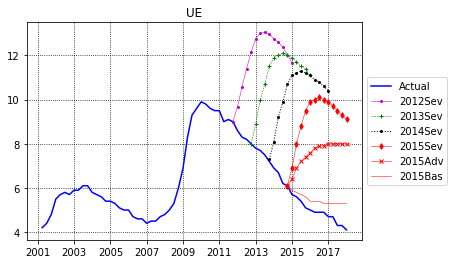

In [9]:
vv = 'UE'
hsx1 = hsx[hsx['Date']>'2001-01-01']
hsx1.set_index('Date', drop=True, inplace=True)
cc2 = ccy[['Date','CCAR','Scen',vv]]
cc2['YrSc'] = cc2.apply(lambda x: str(x['CCAR'])+x['Scen'],axis=1)
cc2p = cc2.pivot('Date','YrSc',vv)
#cc2p.head()
hsx2 = hsx1.merge(cc2p, how='outer', left_index=True, right_index=True)
#hsx2.tail()

x = list(hsx2.index)

plt.plot(x,hsx2[vv],c='b',label='Actual')
plt.plot(x,hsx2['2012Sev'],ls='-',c='m',lw=.5,marker='.',ms=4,label='2012Sev')
plt.plot(x,hsx2['2013Sev'],ls='--',c='g',lw=.5,marker='+',ms=4,label='2013Sev')
plt.plot(x,hsx2['2014Sev'],ls=':',c='k',lw=1,marker='.',ms=4,label='2014Sev')
plt.plot(x,hsx2['2015Sev'],c='r',lw=.5,marker='d',ms=4,label='2015Sev')
plt.plot(x,hsx2['2015Adv'],c='r',lw=.5,marker='x',ms=4,label='2015Adv')
plt.plot(x,hsx2['2015Bas'],c='r',lw=.5,label='2015Bas')
plt.title(vv)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.savefig(vv+'_chart.png', dpi=400, bbox_inches='tight')
plt.show()

In [10]:
hsue = pd.DataFrame(hsy.loc['2001':'2019']['UE'])
hsue.reset_index(drop=False, inplace=True)
hsue.tail()

Date   UE
63 2016-12-31  4.7
64 2017-03-31  4.7
65 2017-06-30  4.3
66 2017-09-30  4.3
67 2017-12-31  4.1

In [11]:
ccs = ccy[ccy['Scen']=='Sev'][['CCAR','Date','UE']]
ccs = ccs.pivot('Date','CCAR','UE')
ccs.reset_index(drop=False, inplace=True)
ccs.columns = ['Date','u12','u13','u14','u15','u16','u17','u18']
ccs.tail()

Date  u12  u13  u14  u15  u16  u17  u18
34 2020-03-31  NaN  NaN  NaN  NaN  NaN  8.9  9.7
35 2020-06-30  NaN  NaN  NaN  NaN  NaN  NaN  9.5
36 2020-09-30  NaN  NaN  NaN  NaN  NaN  NaN  9.2
37 2020-12-31  NaN  NaN  NaN  NaN  NaN  NaN  8.9
38 2021-03-31  NaN  NaN  NaN  NaN  NaN  NaN  8.6

In [12]:
hsue2 = hsue.merge(ccs,how='outer',on='Date')
hsue2.set_index('Date', drop=True, inplace=True)
hsue2.tail()

UE  u12  u13  u14  u15  u16  u17  u18
Date                                             
2020-03-31 NaN  NaN  NaN  NaN  NaN  NaN  8.9  9.7
2020-06-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.5
2020-09-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.2
2020-12-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.9
2021-03-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.6

In [13]:
hsue2['Qn'] = hsue2.index.year * 4 + hsue2.index.month /3
hsue2['Qn'] = hsue2['Qn'].astype(int)
hsue2.tail()

UE  u12  u13  u14  u15  u16  u17  u18    Qn
Date                                                   
2020-03-31 NaN  NaN  NaN  NaN  NaN  NaN  8.9  9.7  8081
2020-06-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.5  8082
2020-09-30 NaN  NaN  NaN  NaN  NaN  NaN  NaN  9.2  8083
2020-12-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.9  8084
2021-03-31 NaN  NaN  NaN  NaN  NaN  NaN  NaN  8.6  8085

In [14]:
mx = hsue2[['UE','u12','u13','u14','u15','u16','u17','u18']].max()
mx = pd.DataFrame(mx)
mx.columns = ['mx']
mxdct = mx.to_dict()
mxdct['mx']

{'UE': 9.9000000000000004,
 'u12': 13.050000000000001,
 'u13': 12.1,
 'u14': 11.300000000000001,
 'u15': 10.1,
 'u16': 10.0,
 'u17': 10.0,
 'u18': 10.0}

In [15]:
mxd = hsue2[hsue2['UE']==mxdct['mx']['UE']]['Qn']
mxd12 = hsue2[hsue2['u12']==mxdct['mx']['u12']]['Qn']
mxd13 = hsue2[hsue2['u13']==mxdct['mx']['u13']]['Qn']
mxd14 = hsue2[hsue2['u14']==mxdct['mx']['u14']]['Qn']
mxd15 = hsue2[hsue2['u15']==mxdct['mx']['u15']]['Qn']
mxd16 = hsue2[hsue2['u16']==mxdct['mx']['u16']]['Qn']
mxd17 = hsue2[hsue2['u17']==mxdct['mx']['u17']]['Qn']
mxd18 = hsue2[hsue2['u18']==mxdct['mx']['u18']]['Qn']
mxd15

Date
2016-06-30    8066
Name: Qn, dtype: int32

In [16]:
mxq = pd.DataFrame(pd.concat([mxd,mxd12,mxd13,mxd14,mxd15,mxd16,mxd17,mxd18]))
mxq.reset_index(drop=False, inplace=True)
ux=pd.Series(['UE','u12','u13','u14','u15','u16','u17','u18'])
mxq = mxq.assign(ux=ux.values)
mxq.set_index('ux',drop=True,inplace=True)
mxq

Date    Qn
ux                  
UE  2009-12-31  8040
u12 2013-06-30  8054
u13 2014-06-30  8058
u14 2015-06-30  8062
u15 2016-06-30  8066
u16 2017-09-30  8071
u17 2018-09-30  8075
u18 2019-09-30  8079

In [17]:
mx2 = mx.merge(mxq, how='inner', left_index=True, right_index=True)
mx2.reset_index(drop=False,inplace=True)
mx2

index     mx       Date    Qn
0    UE   9.90 2009-12-31  8040
1   u12  13.05 2013-06-30  8054
2   u13  12.10 2014-06-30  8058
3   u14  11.30 2015-06-30  8062
4   u15  10.10 2016-06-30  8066
5   u16  10.00 2017-09-30  8071
6   u17  10.00 2018-09-30  8075
7   u18  10.00 2019-09-30  8079

In [18]:
hmx = mx2[mx2['index']=='UE']['mx'][0]
hqn = mx2[mx2['index']=='UE']['Qn'][0]

# calcs incremental adjustment to curr UE rate per period:
for i in np.arange(len(mx2)):
  mx2.loc[i,'adj'] = (1 - hmx / mx2.loc[i,'mx']  )
  mx2.loc[i,'inc'] = (1 - hmx / mx2.loc[i,'mx']  )  /(mx2.loc[i,'Qn'] - hqn)

mx2

index     mx       Date    Qn       adj       inc
0    UE   9.90 2009-12-31  8040  0.000000       NaN
1   u12  13.05 2013-06-30  8054  0.241379  0.017241
2   u13  12.10 2014-06-30  8058  0.181818  0.010101
3   u14  11.30 2015-06-30  8062  0.123894  0.005632
4   u15  10.10 2016-06-30  8066  0.019802  0.000762
5   u16  10.00 2017-09-30  8071  0.010000  0.000323
6   u17  10.00 2018-09-30  8075  0.010000  0.000286
7   u18  10.00 2019-09-30  8079  0.010000  0.000256

In [19]:
hsue2.to_csv('uescaledata.csv')

In [20]:
mx2.to_csv("uescaleparam.csv")

In [21]:
ues = pd.DataFrame(hsue2['Qn'])
ues['adj'] = 1
ues.reset_index(drop=False, inplace=True)
ues.head()

Date    Qn  adj
0 2001-03-31  8005    1
1 2001-06-30  8006    1
2 2001-09-30  8007    1
3 2001-12-31  8008    1
4 2002-03-31  8009    1

In [22]:
## 2012 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u12']['Date']))

inc = np.float(mx2[mx2['index']=='u12']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u12']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj12'}, inplace=True)
ues.head()

Date    Qn  adj12
0 2001-03-31  8005    1.0
1 2001-06-30  8006    1.0
2 2001-09-30  8007    1.0
3 2001-12-31  8008    1.0
4 2002-03-31  8009    1.0

In [23]:
## 2013 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u13']['Date']))

inc = np.float(mx2[mx2['index']=='u13']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u13']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj13'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13
0 2001-03-31  8005    1.0    1.0
1 2001-06-30  8006    1.0    1.0
2 2001-09-30  8007    1.0    1.0
3 2001-12-31  8008    1.0    1.0
4 2002-03-31  8009    1.0    1.0

In [24]:
## 2014 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u14']['Date']))

inc = np.float(mx2[mx2['index']=='u14']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u14']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj14'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14
0 2001-03-31  8005    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0

In [25]:
## 2015 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u15']['Date']))

inc = np.float(mx2[mx2['index']=='u15']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u15']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj15'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15
0 2001-03-31  8005    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0

In [26]:
## 2016 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u16']['Date']))

inc = np.float(mx2[mx2['index']=='u16']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u16']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj16'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0

In [27]:
## 2017 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u17']['Date']))

inc = np.float(mx2[mx2['index']=='u17']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u17']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj17'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16  adj17
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0    1.0

In [28]:
## 2018 adjustment:
ues['adj'] = 1.0
ast = pd.to_datetime(list(mx2[mx2['index']=='UE']['Date']))
aen = pd.to_datetime(list(mx2[mx2['index']=='u18']['Date']))

inc = np.float(mx2[mx2['index']=='u18']['inc'])
adj = np.float(1.0 - mx2[mx2['index']=='u18']['adj'])
cadj = 1.0
for i in np.arange(len(ues)):
  if pd.to_datetime(ues.ix[i]['Date']) >= aen:
    ues.loc[i,'adj'] = adj
  elif pd.to_datetime(ues.ix[i]['Date']) > ast:
    cadj = cadj - inc
    ues.loc[i,'adj'] = cadj

ues.rename(columns={'adj':'adj18'}, inplace=True)
ues.head()

Date    Qn  adj12  adj13  adj14  adj15  adj16  adj17  adj18
0 2001-03-31  8005    1.0    1.0    1.0    1.0    1.0    1.0    1.0
1 2001-06-30  8006    1.0    1.0    1.0    1.0    1.0    1.0    1.0
2 2001-09-30  8007    1.0    1.0    1.0    1.0    1.0    1.0    1.0
3 2001-12-31  8008    1.0    1.0    1.0    1.0    1.0    1.0    1.0
4 2002-03-31  8009    1.0    1.0    1.0    1.0    1.0    1.0    1.0

In [29]:
ues.drop('Qn', axis=1, inplace=True)
ues.tail()

Date     adj12     adj13     adj14     adj15  adj16  adj17  adj18
76 2020-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
77 2020-06-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
78 2020-09-30  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
79 2020-12-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99
80 2021-03-31  0.758621  0.818182  0.876106  0.980198   0.99   0.99   0.99

In [30]:
ues.to_csv("UE_adj.csv")

In [31]:
ues[35:64]

Date     adj12     adj13     adj14     adj15     adj16     adj17  \
35 2009-12-31  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
36 2010-03-31  0.982759  0.989899  0.994368  0.999238  0.999677  0.999714   
37 2010-06-30  0.965517  0.979798  0.988737  0.998477  0.999355  0.999429   
38 2010-09-30  0.948276  0.969697  0.983105  0.997715  0.999032  0.999143   
39 2010-12-31  0.931034  0.959596  0.977474  0.996954  0.998710  0.998857   
40 2011-03-31  0.913793  0.949495  0.971842  0.996192  0.998387  0.998571   
41 2011-06-30  0.896552  0.939394  0.966211  0.995430  0.998065  0.998286   
42 2011-09-30  0.879310  0.929293  0.960579  0.994669  0.997742  0.998000   
43 2011-12-31  0.862069  0.919192  0.954948  0.993907  0.997419  0.997714   
44 2012-03-31  0.844828  0.909091  0.949316  0.993145  0.997097  0.997429   
45 2012-06-30  0.827586  0.898990  0.943685  0.992384  0.996774  0.997143   
46 2012-09-30  0.810345  0.888889  0.938053  0.991622  0.996452  0.996857   
47 2012-12-31  0.793103  0.878788  0.932422  0.990861  0.996129  0.996571   
48 2013-03-31  0.775862  0.868687  0.926790  0.990099  0.995806  0.996286   
49 2013-06-30  0.758621  0.858586  0.921158  0.989337  0.995484  0.996000   
50 2013-09-30  0.758621  0.848485  0.915527  0.988576  0.995161  0.995714   
51 2013-12-31  0.758621  0.838384  0.909895  0.987814  0.994839  0.995429   
52 2014-03-31  0.758621  0.828283  0.904264  0.987053  0.994516  0.995143   
53 2014-06-30  0.758621  0.818182  0.898632  0.986291  0.994194  0.994857   
54 2014-09-30  0.758621  0.818182  0.893001  0.985529  0.993871  0.994571   
55 2014-12-31  0.758621  0.818182  0.887369  0.984768  0.993548  0.994286   
56 2015-03-31  0.758621  0.818182  0.881738  0.984006  0.993226  0.994000   
57 2015-06-30  0.758621  0.818182  0.876106  0.983244  0.992903  0.993714   
58 2015-09-30  0.758621  0.818182  0.876106  0.982483  0.992581  0.993429   
59 2015-12-31  0.758621  0.818182  0.876106  0.981721  0.992258  0.993143   
60 2016-03-31  0.758621  0.818182  0.876106  0.980960  0.991935  0.992857   
61 2016-06-30  0.758621  0.818182  0.876106  0.980198  0.991613  0.992571   
62 2016-09-30  0.758621  0.818182  0.876106  0.980198  0.991290  0.992286   
63 2016-12-31  0.758621  0.818182  0.876106  0.980198  0.990968  0.992000   

       adj18  
35  1.000000  
36  0.999744  
37  0.999487  
38  0.999231  
39  0.998974  
40  0.998718  
41  0.998462  
42  0.998205  
43  0.997949  
44  0.997692  
45  0.997436  
46  0.997179  
47  0.996923  
48  0.996667  
49  0.996410  
50  0.996154  
51  0.995897  
52  0.995641  
53  0.995385  
54  0.995128  
55  0.994872  
56  0.994615  
57  0.994359  
58  0.994103  
59  0.993846  
60  0.993590  
61  0.993333  
62  0.993077  
63  0.992821